<a href="https://colab.research.google.com/github/jwells52/creating-ai-enabled-systems/blob/main/Research%20Project/notebooks/fsl_experiment3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Install easyfsl

In [1]:
%pip install easyfsl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.2/65.2 kB 1.3 MB/s eta 0:00:00


### Download Humpback Whale Dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!rm -rf /root/.kaggle && mkdir /root/.kaggle && cp /content/drive/MyDrive/Research-Project/kaggle.json /root/.kaggle/kaggle.json && chmod 600 /root/.kaggle/kaggle.json && kaggle competitions download -c humpback-whale-identification

100% 5.50G/5.51G [03:18<00:00, 37.6MB/s]
100% 5.51G/5.51G [03:18<00:00, 29.8MB/s]


In [4]:
%%capture

!unzip humpback-whale-identification.zip

### Clone GitHub Repo

In [5]:
!git clone https://github.com/jwells52/creating-ai-enabled-systems.git
%cd creating-ai-enabled-systems/Research\ Project

Cloning into 'creating-ai-enabled-systems'...
remote: Enumerating objects: 294, done.
remote: Counting objects: 100% (107/107), done.
remote: Compressing objects: 100% (98/98), done.
remote: Total 294 (delta 63), reused 23 (delta 7), pack-reused 187
Receiving objects: 100% (294/294), 159.05 MiB | 30.13 MiB/s, done.
Resolving deltas: 100% (142/142), done.
Updating files: 100% (48/48), done.
/content/creating-ai-enabled-systems/Research Project


### Imports

In [ ]:
import os
import cv2
import torch

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm

from easyfsl.methods import PrototypicalNetworks, FewShotClassifier, SimpleShot
from easyfsl.utils import evaluate, evaluate_on_one_task
from easyfsl.samplers import TaskSampler

from torch import Tensor, nn
from torch.optim import SGD, Optimizer, Adam
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet18, resnet34, resnet152

from typing import Callable

from modules.data_utils import HumpbackWhaleDataset, remove_new_whale_class, create_loaders
from modules.train import train_fsl, device, transform


%load_ext autoreload
%autoreload 2

### Look at classes that have low performance

In [ ]:
# Load into dataset
# For each class, calculate accuracy
# Then plot barplot of accuracy for each class
# Look at the characteristics of images for the classes that have low performance

In [ ]:
df = remove_new_whale_class(
  pd.read_csv('/content/creating-ai-enabled-systems/Research Project/data/validation_10samples.csv')
)


# df = df[df['class_count'] > 15]

In [ ]:
df

,Image,Id,class_count
0,006500b3d.jpg,w_a8b34a0,16
1,009c45bc7.jpg,w_2df85e7,16
2,00caa5c60.jpg,w_fccccec,14
3,00d6cbcbf.jpg,w_6f0cbe3,11
4,00d831b06.jpg,w_6e209a8,13
...,...,...,...
775,fde9b67f0.jpg,w_2b069ba,48
776,fea2fc401.jpg,w_972e51e,12
777,fefec451f.jpg,w_343f088,40
778,ffca5cb22.jpg,w_51e7506,15


In [ ]:
len(df['Id'].unique())

46

In [ ]:
class PrototypicalNetworksLocal(torch.nn.Module):
    def __init__(self, backbone: nn.Module):
        super(PrototypicalNetworksLocal, self).__init__()
        self.backbone = backbone

    def forward(
        self,
        support_images: torch.Tensor,
        support_labels: torch.Tensor,
        query_images: torch.Tensor,
    ) -> torch.Tensor:
        """
        Predict query labels using labeled support images.
        """
        # Extract the features of support and query images
        z_support = self.backbone.forward(support_images)
        z_query = self.backbone.forward(query_images)


        # Infer the number of different classes from the labels of the support set
        n_way = len(torch.unique(support_labels))

        # Prototype i is the mean of all instances of features corresponding to labels == i
        z_proto = torch.cat(
            [
                z_support[torch.nonzero(support_labels == label)].mean(0)
                for label in support_labels
            ]
        )

        # Compute the euclidean distance from queries to prototypes
        dists = torch.cdist(z_query, z_proto)

        # And here is the super complicated operation to transform those distances into classification scores!
        scores = -dists
        return scores

In [ ]:
cnn = resnet34().to(device)
cnn.fc = torch.nn.Flatten()
few_shot_classifier = PrototypicalNetworksLocal(cnn).to(device)
few_shot_classifier.load_state_dict(
  torch.load('/content/drive/MyDrive/prod_checkpoint')
)

<All keys matched successfully>

In [ ]:
few_shot_classifier.eval()

PrototypicalNetworksLocal(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, aff

In [ ]:
n_way   = 5
n_shot  = 3
n_query = 5

In [ ]:
####################################
# Evaluate accuracy for each class
###################################

# For each class
#  create a query set containing class examples
#  create a support set containing N classes
#  pass query set and support set in evaluate function from easyfsl

In [ ]:
def image_reader_single(path):
  image = cv2.imread(path)
  image = cv2.resize(image, (512, 256))
  return image

In [ ]:
class2idx = {k:i for i, k in enumerate(df['Id'].unique())}
idx2class = {i:k for k, i in class2idx.items()}

In [ ]:
class_accs = dict()
for q_id, df_id in df.groupby('Id'):
  _df = df.copy()

  # Create query set
  query_set_labels = np.array([class2idx[q_id] for _ in range(n_query)])
  query_set_images_paths = np.random.choice(df_id['Image'], size=n_query)
  query_set_images = np.array(
      [
          image_reader_single(os.path.join('/content/train', image))
            for image in query_set_images_paths
      ]
    )

  # Remove query images from dataset
  _df = _df[~_df['Image'].isin(query_set_images_paths)]

  # Create support set
  support_classes = np.random.choice(_df['Id'].unique(), size=n_way, replace=False)
  support_classes = np.array([class2idx[s_id] for s_id in support_classes] + [class2idx[q_id]])

  support_set_labels = np.zeros((n_way+1)*n_shot, dtype=int)
  support_set_images = np.zeros(((n_way+1)*n_shot, 256, 512, 3))

  cnt = 0
  for i, s_id in enumerate(support_classes):
    class_support_set_image_paths = np.random.choice(_df[_df['Id'] == idx2class[s_id]]['Image'], size=n_shot)
    for image_path in class_support_set_image_paths:
      support_set_labels[cnt] = s_id
      support_set_images[cnt] = image_reader_single(os.path.join('/content/train', image_path))
      cnt += 1

  # Convert sets to Tensors
  query_set_labels_tensor = torch.Tensor(query_set_labels).to(device)
  query_set_images_tensor = transform(torch.Tensor(query_set_images).to(device).permute(0, 3, 1, 2))
  support_set_labels_tensor = torch.Tensor(support_set_labels).to(device)
  support_set_images_tensor = transform(torch.Tensor(support_set_images).to(device).permute(0, 3, 1, 2))

  # Pass support set and query set through Prototypical Network
  predictions = few_shot_classifier(support_set_images_tensor, support_set_labels_tensor, query_set_images_tensor).detach().data
  predicted_labels = support_set_labels_tensor[torch.max(predictions, 1)[1]]
  print(predicted_labels)
  print(query_set_labels_tensor)
  print(support_set_labels_tensor)

  num_correct = (
    (predicted_labels == query_set_labels_tensor).sum().item()
  )

  class_accs[q_id] = num_correct/n_query

  print(f'Whale Id: {q_id} | num_correct={num_correct} | len_query={n_query}')
  print('\n\n\n')



tensor([25., 25., 18., 11., 25.], device='cuda:0')
tensor([37., 37., 37., 37., 37.], device='cuda:0')
tensor([25., 25., 25., 18., 18., 18., 32., 32., 32.,  1.,  1.,  1., 11., 11.,
        11., 37., 37., 37.], device='cuda:0')
Whale Id: w_0887d9b | num_correct=0 | len_query=5




tensor([20., 20., 20., 18., 18.], device='cuda:0')
tensor([18., 18., 18., 18., 18.], device='cuda:0')
tensor([14., 14., 14., 32., 32., 32.,  5.,  5.,  5., 20., 20., 20., 29., 29.,
        29., 18., 18., 18.], device='cuda:0')
Whale Id: w_0fdf741 | num_correct=2 | len_query=5




tensor([30., 30., 30.,  9.,  9.], device='cuda:0')
tensor([39., 39., 39., 39., 39.], device='cuda:0')
tensor([30., 30., 30.,  9.,  9.,  9., 25., 25., 25., 22., 22., 22., 39., 39.,
        39., 39., 39., 39.], device='cuda:0')
Whale Id: w_15805cd | num_correct=0 | len_query=5




tensor([33., 22.,  0., 22., 33.], device='cuda:0')
tensor([22., 22., 22., 22., 22.], device='cuda:0')
tensor([33., 33., 33., 19., 19., 19.,  0.,  0.,  0., 10., 

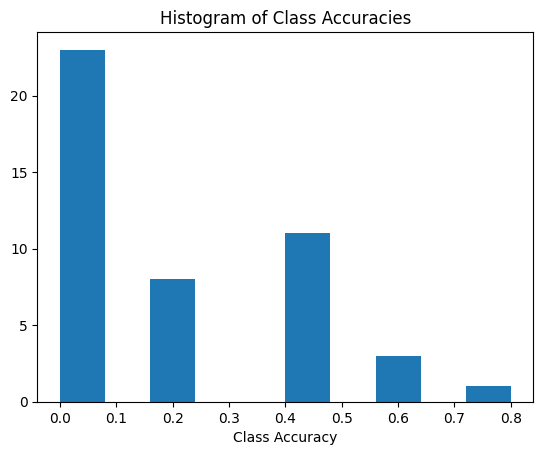

In [ ]:
plt.title('Histogram of Class Accuracies')
plt.hist(class_accs.values())
plt.xlabel('Class Accuracy');